In [1]:
# !export XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda/
!export CUDA_DIR=/usr/lib/cuda/
# !export LD_LIBRARY_PATH=/usr/local/cuda-11.8/lib64:/home/pedro/miniconda3/envs/ml2/lib/
# !export TF_GPU_ALLOCATOR=cuda_malloc_async

In [2]:
!ls ${CUDA_DIR}/nvvm/libdevice

libdevice.10.bc


In [3]:
# %load_ext autoreload
# %autoreload 2

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
import math

gpus = tf.config.list_physical_devices("GPU")
print(f"gpus={gpus}")

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
import tensorflow_addons as tfa
import datetime
import random
from sklearn.model_selection import train_test_split
import time

import os
import re
import pathlib

2023-01-14 00:33:24.585656: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 00:33:24.679296: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-14 00:33:25.133313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2023-01-14 00:33:25.133353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or

gpus=[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
# !wget https://drive.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

In [6]:
def add_vertical_lines_noise(x, shifts=2, line_height=2):
    x = np.copy(x)
    axis_for_roll = 1
    y = np.roll(x, -shifts, axis=axis_for_roll)
    j = 0
    for i in range(x.shape[axis_for_roll]):
        if j <= line_height:
            x[:,i,:] = y[:,i,:]
            
        j+=1
        if j == line_height * 2:
            j = 0
#     print(x.shape)
    return x

def add_horizontal_lines_noise(x, shifts=2, line_height=2):
    x = np.copy(x)
    axis_for_roll = 0
    y = np.roll(x, -shifts, axis=1)
    j = 0
    for i in range(x.shape[axis_for_roll]):
        if j <= line_height:
            x[i,:,:] = y[i,:,:]
            
        
        if j == line_height * 2:
            j = 0
        else:
            j+=1
#     print(x.shape)
    return x

In [7]:
import tensorflow_datasets as tfds
from functools import reduce
splits = tfds.even_splits('train', n=200, drop_remainder=True)

In [8]:
IMG_H = 480
IMG_W = 720
IMG_CHANNELS = 3

In [9]:
# train_len = 7164

In [10]:
# BATCH_SIZE = 3
# EPOCHS=100
# steps_per_epoch=int(train_len/BATCH_SIZE)

In [11]:
from utils import NoiseUtil, ImgUtils, DataLoader, DataManager

           
def add_noise(x,y):
    downsize_image_ratio = random.choice([1/5])
    sh = tf.cast(tf.shape(x), tf.float32)
    
    print(x)
    
    resized_size_h = sh[0]
    resized_size_w = sh[1]
    down = tf.image.resize(
        x,
        [int(resized_size_h * downsize_image_ratio), int(resized_size_w * downsize_image_ratio)],
        preserve_aspect_ratio=True,
        antialias=False,
        name=None)
    
    

    x= tf.image.resize(
        down,
        [resized_size_h, resized_size_w],
        preserve_aspect_ratio=True,
        antialias=False,
        name=None)
        
    return tf.reshape(x, (resized_size_h, resized_size_w, 3)), y
    
    
#     print(x.shape)

    
#     n = NoiseUtil.pixel_noise(x, random.choice([50,60]), 15, downsize_image_ratios=[1/4, 1/6])

#     n = x + 0.2 * tf.random.normal(
#         x.shape[1:],
#         mean=0.0,
#         stddev=1.0,
#         dtype=tf.dtypes.float32,
#     )

#     return n,y

random_bright = tf.keras.layers.RandomBrightness(factor=0.2)
random_contrast = tf.keras.layers.RandomContrast(factor=0.2)
random_flip = tf.keras.layers.RandomFlip()


def augment(x):
#     seed = (random.randint(0, 100),random.randint(0, 100))
    x = random_bright(x, training=True)
    x = random_contrast(x, training=True)
    x = random_flip(x, training=True)
    return x

def get_train_data():
    return tf.data.Dataset.from_generator(train_gen, output_signature=tf.TensorSpec(shape=(480, 720, 3)))
    
def get_test_data():
    return tf.data.Dataset.from_generator(test_gen, output_signature=tf.TensorSpec(shape=(480, 720, 3)))


def get_dist_ds(ds, ds_len):
    c = ds.map(normm).map(expp).map(augment)
    a = c.map(lambda y: (y,1))
    b = c.map(lambda y: (y,0)).map(add_noise)
    return a.concatenate(b).batch(BATCH_SIZE)

def get_gen_ds(ds):
    return ds.map(augment).map(lambda x: (x,x)).map(add_noise).batch(BATCH_SIZE)

# train_ds = get_gen_ds(get_train_data())
# test_ds = get_gen_ds(get_test_data())

2023-01-14 00:33:26.332596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 00:33:26.420694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 00:33:26.420895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 00:33:26.421072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [12]:
def print_validation(model=lambda x:x, batch_size=5, save=False, path="./", max_size=20, datasets=([], [])):
        rows = batch_size
        cols = 3
        train_ds, test_ds = datasets
        def print_ds(dataset, save=False):
            results = [(model(x),x, y) for x,y in dataset]
            plt.ion()
            plt.show()
            print(rows, cols)
            plt.figure(figsize=((max_size+15) / cols, max_size / rows))
            for x,x_prev, y in results:
#                 x = (x * 127.5) + 127.5
#                 y = (y * 127.5) + 127.5
#                 x_prev = (x_prev * 127.5) + 127.5
#                 x = x * 255.
#                 y = y * 255.
#                 x_prev = x_prev * 255.

                x = tf.cast(x, tf.uint8)
                x_prev = tf.cast(x_prev, tf.uint8)
                y = tf.cast(y, tf.uint8)
#                 x = tf.clip_by_value(x, 0.0, 1.0)
#                 y = tf.clip_by_value(y, 0.0, 1.0)
                assert x.shape == y.shape
    
                for i in range(x.shape[0]):
                    im = x[i,:,:,:]
                    plt.subplot(cols, rows, i+1)
                    plt.imshow(im)
                    plt.title("Denoised")
                    plt.axis('off')
                    
                for i in range(x_prev.shape[0]):
                    im = x_prev[i,:,:,:]
                    plt.subplot(cols, rows, i+x_prev.shape[0]+1)
                    plt.imshow(im)
                    plt.title("With noise")
                    plt.axis('off')


                for i in range(y.shape[0]):
                    im = y[i,:,:,:]
                    plt.subplot(cols, rows, i+x.shape[0]+x_prev.shape[0]+1)
                    plt.imshow(im)
                    plt.title("Original")
                    plt.axis('off')
            plt.subplots_adjust(wspace = 0.1, hspace = 0.5)
            if save:
                plt.savefig(path)
        
            plt.draw()
            plt.pause(0.001)
            
        print_ds(test_ds.map(lambda x,y: (x[0], y[0])).take(batch_size).batch(batch_size), save=save)
        print_ds(train_ds.map(lambda x,y: (x[0], y[0])).take(batch_size).batch(batch_size), save=False)
        
# print_validation(model=lambda x:x, batch_size=2, save=False, path="./", datasets=(train_ds, test_ds))

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow.keras.backend as K

def build_perceptual_loss(input_shape=(480, 720, 3)):
    print(input_shape)
    vgg = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    vgg.trainable = False ## Not trainable weights


    selected_layers = ['block1_conv1', 'block2_conv2',"block3_conv3" ,'block4_conv3','block5_conv3']
    selected_layer_weights = [1.0, 4.0 , 4.0 , 8.0 , 16.0]


    outputs = [vgg.get_layer(l).output for l in selected_layers]
    prediction_model = Model(vgg.input, outputs)

    def perceptual_loss(input_image , reconstruct_image):
        input_image = tf.keras.applications.vgg16.preprocess_input(input_image)
        reconstruct_image = tf.keras.applications.vgg16.preprocess_input(reconstruct_image)

        h1_list = prediction_model(input_image)
        h2_list = prediction_model(reconstruct_image)

        rc_loss = 0.0

        for h1, h2, weight in zip(h1_list, h2_list, selected_layer_weights):
            h1 = K.batch_flatten(h1)
            h2 = K.batch_flatten(h2)
            rc_loss = rc_loss + weight * K.sum(K.square(h1 - h2), axis=-1)

        return rc_loss
    
    return perceptual_loss

In [14]:
# train_len

# small_epochs = 30


# small_steps_per_epoch = int((train_len/small_epochs)/BATCH_SIZE)
# small_steps_per_epoch

In [15]:
# def build_autoencoder():
#     inputs = keras.Input(shape=(480, 720, 3))
#     reg = tf.keras.regularizers.l1_l2(0.1,0.1)
#     act = layers.LeakyReLU(alpha=0.2)
# #     args = {"padding":'same', "activation":act, "activity_regularizer":reg}
#     args = {"padding":'same', "activation":act, "kernel_initializer":tf.keras.initializers.HeNormal(seed=32)}
    
#     x = tf.keras.layers.Rescaling(1./255)(inputs)
#     x = layers.Conv2D(128, kernel_size=5, strides=1, dilation_rate=2, **args)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPool2D(2,2)(x)
#     x = layers.SpatialDropout2D(0.3)(x)
#     x = layers.Conv2D(128, kernel_size=3, strides=1, dilation_rate=2, **args)(x)
#     x = layers.MaxPool2D(2,2)(x)
#     x = layers.SpatialDropout2D(0.3)(x)
#     x = layers.Conv2D(128, kernel_size=3, strides=1, **args)(x)
#     x = layers.MaxPool2D(2,2)(x)
#     x = layers.Conv2D(256, kernel_size=5, strides=2, **args)(x)
#     x = layers.Conv2D(512, kernel_size=(2,3), strides=(2,3), **args)(x)
    
#     x = layers.Conv2DTranspose(512, kernel_size=(3,3), strides=(2,3), **args)(x)
#     x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, **args)(x)
#     x = layers.Conv2DTranspose(128, kernel_size=2, strides=2, **args)(x)
#     x = layers.Conv2DTranspose(128, kernel_size=3, strides=1, **args)(x)
#     x = layers.UpSampling2D(2)(x)
#     x = layers.Conv2DTranspose(64, kernel_size=3, strides=1, **args)(x)
#     x = layers.UpSampling2D(2)(x)
#     x = layers.Conv2DTranspose(32, kernel_size=3, strides=1, **args)(x)
#     x = layers.Conv2DTranspose(3, kernel_size=3, strides=1, **args)(x)
    
#     return tf.keras.Model(inputs, x)
    

# autoencoder = build_autoencoder()

class RenderImages(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        images_path = f"./col_100_output_images/"
        image_name = images_path + f"e_{epoch}.jpg"
#         display.clear_output()
        print_validation(lambda x:autoencoder(x, training=False), batch_size=5, save=False, path="./")
        
class LRMetric(tf.keras.metrics.Mean):
    def update_state(self, y_true, y_pred, sample_weight=None):
        lr = autoencoder.optimizer.lr
        current_lr = lr(autoencoder.optimizer.iterations)
        super().update_state(current_lr)
        
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=False,
#                                                               patience=10, min_delta=0.)  

       


## Remove horizontal lines

In [16]:
def pixelation_noise(x):
    downsize_image_ratio = random.choice([1/2,1/5,1/10, 1/12])
    sh = tf.cast(tf.shape(x), tf.float32)
    
    resized_size_h = sh[0]
    resized_size_w = sh[1]
    down = tf.image.resize(
        x,
        [int(resized_size_h * downsize_image_ratio), int(resized_size_w * downsize_image_ratio)],
        preserve_aspect_ratio=True,
        antialias=False,
        name=None)
    x= tf.image.resize(
        down,
        [resized_size_h, resized_size_w],
        preserve_aspect_ratio=True,
        antialias=False,
        name=None)
    return x

def get_right_dims(shape):
    print(shape)
    h, w, c = shape
    # 624, 936
    while h > 624*1.5 and w > 936*1.5:
        h *= 0.9
        w *= 0.9
    h *= 1.1
    w *= 1.1
    return (int(h),int(w))

def random_brightness(x):
#     x = tf.image.random_brightness(x, 0.2)
    x = tf.image.random_contrast(x, 0.2, 0.5)
    return x

def manual_filter(slice_paths):
    count = 1055
    for idx, (filename, img_type) in enumerate(slice_paths):
        input_w = 720
        input_h = 480
        raw_image = tf.io.read_file(filename, name=filename)
        if img_type == "png":
            img = tf.image.decode_png(raw_image, channels=3, name=filename)
        elif img_type == "jpg" or img_type == "jpeg":
            img = tf.image.decode_jpeg(raw_image, channels=3, name=filename)
            
        h,w = get_right_dims(img.shape)

        img = tf.image.resize(
            img,
            [h, w],
            preserve_aspect_ratio=True,
            antialias=False,
            name=None)
        img = tf.cast(img, tf.uint8)

        for i in range(100):
            # * 1.3
            cropped = tf.image.random_crop(
              img, size=[624, 936, 3]
            )
            cropped_small = tf.image.resize(
                cropped,
                [480, 720],
                preserve_aspect_ratio=True,
                antialias=False,
                name=None)
            
            ts = [lambda x: add_horizontal_lines_noise(x.numpy(), random.randint(-10, -8), random.randint(2, 5)),
                 pixelation_noise,
                  lambda x: add_horizontal_lines_noise(pixelation_noise(x).numpy(), random.randint(-10, -8), random.randint(2, 5))
                 ]
            
            fn = random.choice(ts)
            cropped_small = fn(cropped_small)
            
            cropped_small = tf.cast(cropped_small, tf.uint8)
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            plt.title(f"{cropped.shape}")
            plt.imshow(cropped)
            plt.axis("Off")
            plt.subplot(1,2,2)
            plt.title(f"{cropped_small.shape}")
            plt.imshow(cropped_small)
            plt.axis("Off")
            plt.ion()
            plt.show()
            x = input()
            
            display.clear_output()
            print(f"Count={count}")
            if x == "3":
                break
            if x == "1":
                count += 1
                print("Saved!")
                path1 = "./upscale_imgs/"
                create_dir(path1)
                Image.fromarray(cropped.numpy()).save(f"{path1}/{count}_large.jpeg")
                Image.fromarray(cropped_small.numpy()).save(f"{path1}/{count}_small.jpeg")

# manual_filter(large_images)

#                 for y1 in yield_resized_cropped(img, "p{}_{}.jpeg"):

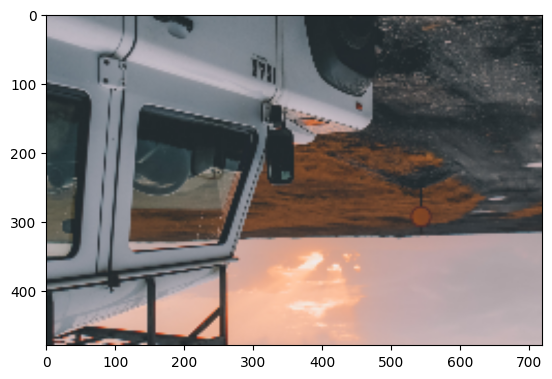

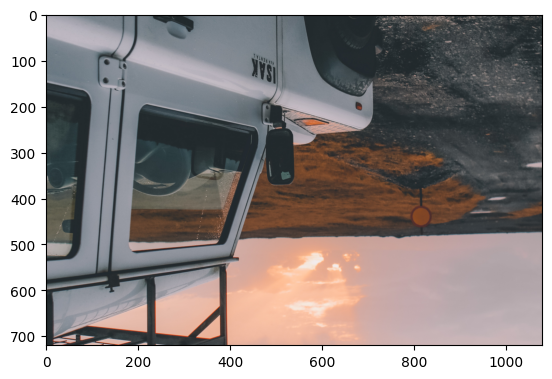

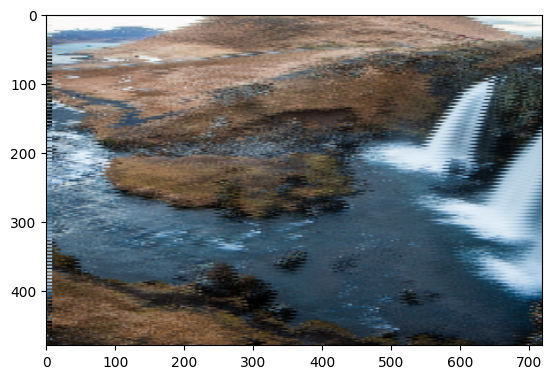

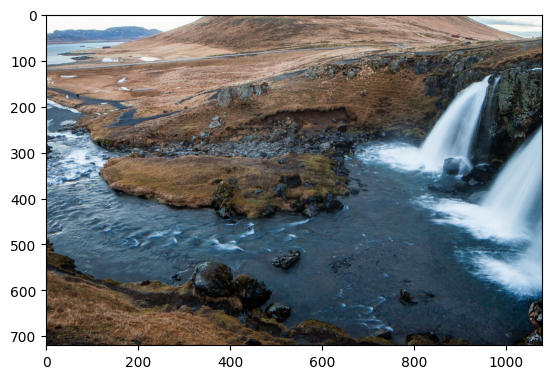

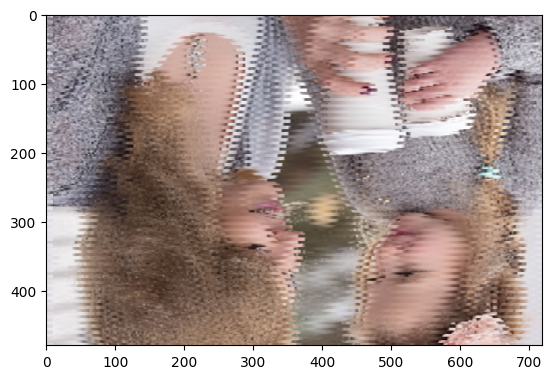

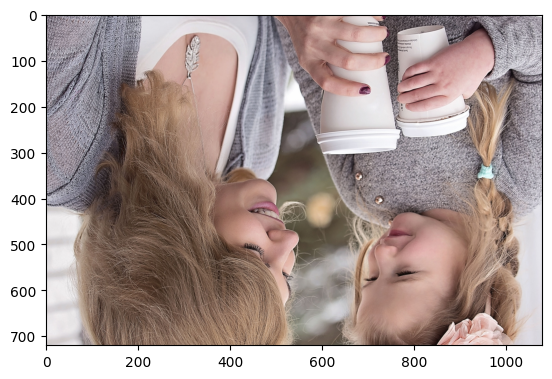

In [17]:
import tensorflow_datasets as tfds

def unsharp(x):
    image = Image.fromarray(x)
    return image.filter(ImageFilter.UnsharpMask(radius=2, percent=150))

def pixelation_noise(x, ranges=[1/3]):
    downsize_image_ratio = random.choice(ranges)
    sh = tf.cast(tf.shape(x), tf.float32)
    
    resized_size_h = sh[0]
    resized_size_w = sh[1]
    down = tf.image.resize(
        x,
        [int(resized_size_h * downsize_image_ratio), int(resized_size_w * downsize_image_ratio)],
        preserve_aspect_ratio=True,
        antialias=False,
        name=None)
    x= tf.image.resize(
        down,
        [resized_size_h, resized_size_w],
        preserve_aspect_ratio=True,
        antialias=False,
        name=None)
    return x

def random_invert_img(x, p=0.5):
    if  tf.random.uniform([]) < p:
        x = (255-x)
    else:
        x
    return x

def augment_img(x):
#     x = tf.image.stateless_random_brightness(x, 0.2, seed)
#     x = tf.image.random_contrast(x, 0.2, 0.5)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = random_invert_img(x, p=0.4)
    return x

@tf.function
def random_noise(y):
    x = tf.image.resize(y, size=[480, 720])
    def rn(x):
        
        ts = [
            lambda x: add_horizontal_lines_noise(x, random.randint(-10, -8), random.randint(2, 5)),
            pixelation_noise,
#             lambda x: unsharp(np.array(x)), 
            lambda x: add_horizontal_lines_noise(pixelation_noise(x,ranges=[1/3]), random.randint(-10, -8), random.randint(2, 5))
             ]

        fn = random.choice(ts)

        return fn(x)

    return tf.numpy_function(func=rn, inp=[x], Tout=tf.float32), y

def div2k_ds(split):
    return tfds.load('div2k', split=split, shuffle_files=True)\
        .map(lambda x: x["hr"])\
        .map(lambda y:tf.image.resize_with_crop_or_pad(y, 720, 1080))\
        .map(lambda z: tf.cast(z, tf.float32))\
        .map(augment_img)\
        .map(random_noise)

div2k_ds_train = div2k_ds('train')
div2k_ds_test = div2k_ds('validation')

i = iter(div2k_ds_train)
for j in range(3):
    x, y = next(i)
    plt.figure()
    plt.imshow(tf.cast(x, tf.uint8))
    plt.figure()
    plt.imshow(tf.cast(y, tf.uint8))

In [18]:
# large_train_ds = create_ds(train_gen).batch(2)
# large_test_ds = create_ds(test_gen).batch(1)

# large_train_ds = create_ds_2(large_train).batch(2)
# large_test_ds = create_ds_2(large_test).batch(1)



#x = tfa.layers.GroupNormalization()(x)
# = layers.SpatialDropout2D(0.3)(x)
#x = layers.UpSampling2D((2,3))(x)

class MyRescale(tf.keras.layers.Layer):
  def __init__(self):
    super(MyRescale, self).__init__()
  def build(self, input_shape):
     self.kernel = self.add_weight("kernel", initializer=tf.keras.initializers.Constant(value=255))


  def call(self, inputs):
   return inputs * self.kernel

class MyConcat(tf.keras.layers.Layer):
  def __init__(self):
    super(MyConcat, self).__init__()
  def build(self, input_shape):
     self.kernel = self.add_weight("kernel", initializer=tf.keras.initializers.Constant(value=1))


  def call(self, inputs):
    x, y = inputs
    return tf.concat([x,y* self.kernel], axis=-1) 

def subpixel_deconv(filters, kernel_size, downsampleFactor):
    def fn(x):
#         print(f"filters={filters}, downsampleFactor={downsampleFactor}, all_filters={filters * (downsampleFactor ** 2)}")
        x = tf.keras.layers.Conv2D(filters * (downsampleFactor ** 2), kernel_size, activation="relu", padding="same", kernel_initializer="Orthogonal")(x)
        x = tf.nn.depth_to_space(x, downsampleFactor)
        return x
    return fn

class MyDeconv(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides, name, resize_to=None, norm=True):
        super(MyDeconv, self).__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size
        self.resize_to = resize_to
        self.strides = strides
        self.norm = norm
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "resize_to": self.resize_to,
            "strides": self.strides,
        })
        return config
        
    def build(self, input_shape):
        filters = self.filters
        kernel_size = self.kernel_size
        name = self.name
        
        strides = self.strides if isinstance(self.strides, tuple) else (self.strides,self.strides)
                     
        if self.resize_to is None:
            h,w = input_shape[1], input_shape[2]
            self.resize_to = (int(h*strides[0]),int(w*strides[1]))
        
        self.resize_layer = layers.Lambda(lambda x: tf.image.resize(x, self.resize_to, method="nearest"), name=f"resize_nearest_{name}")
        
        def build_conv(filters, kernel_size, name):
            conv = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding="same", use_bias=True,
                              activation="relu",
    #                           kernel_initializer=tf.keras.initializers.HeNormal(seed=32),
                              name=name)
            if self.norm:
                return tfa.layers.SpectralNormalization(conv, name=f"{name}_spectral_norm")
            else:
                return conv
            
        self.conv1 = build_conv(filters, kernel_size, name=f"{name}_1")
        self.conv2 = build_conv(filters, kernel_size, name=f"{name}_2")
        self.conv3 = build_conv(filters, kernel_size, name=f"{name}_3")
        self.conv4 = build_conv(filters, kernel_size, name=f"{name}_4")
        

    def call(self, inputs):
        x = self.resize_layer(inputs)
        x = self.conv1(x)
        x = self.conv2(x)
        y = x
        x = self.conv3(x)
        x = self.conv4(x)
        x = layers.add([x,y])
        x = tf.keras.activations.relu(x)
        return x

# def get_activation():
    # return layers.LeakyReLU(alpha=0.2)
act = layers.LeakyReLU(alpha=0.2)

def maxconv_name():
    i = 0
    while True:
        i += 1
        yield f"max_conv_{i}"
        
def deconv_name():
    i = 0
    while True:
        i += 1
        yield f"deconv_{i}"
        
max_conv_name = iter(maxconv_name())
deconv_name_i = iter(deconv_name())

def deconv(filters, kernel_size, strides, name, norm=False, activation="relu", **args):
    if norm:
        return tfa.layers.SpectralNormalization(
            layers.Conv2DTranspose(filters, kernel_size=kernel_size, strides=strides, padding="same", use_bias=False,
                          activation=activation, kernel_initializer=tf.keras.initializers.HeNormal(seed=32),
                          name=name, **args), name=f"{name}_spectral_norm")
    return layers.Conv2DTranspose(filters, kernel_size=kernel_size, strides=strides, padding="same", use_bias=False, 
                      activation=activation, kernel_initializer=tf.keras.initializers.HeNormal(seed=32),
                      name=name, **args)

def conv(filters, kernel_size, strides, name, norm=False, use_init = True, use_bias=False, activation="relu", **args):
    if norm:
        return tfa.layers.SpectralNormalization(
            layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding="same", use_bias=use_bias,
                          activation=activation,
                          kernel_initializer=tf.keras.initializers.HeNormal(seed=32) if use_init else None,
                          name=name, **args), name=f"{name}_spectral_norm")
    return layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding="same", use_bias=use_bias,
                      activation=activation,
                      kernel_initializer=tf.keras.initializers.HeNormal(seed=32) if use_init else None,
                      name=name, **args)

def maxpoolconv(filters, pool_kernel_size, kernel_size=3, strides=1, norm=True):
    name = next(max_conv_name)
    def fn(x):
        x = conv(filters, kernel_size=kernel_size, strides=1, name=f"{name}_1", norm=norm)(x)
        y = x
        x = conv(filters, kernel_size=kernel_size, strides=1, name=f"{name}_2", norm=norm)(x)
        x = conv(filters, kernel_size=kernel_size, strides=1, name=f"{name}_3", norm=norm)(x)
        x = layers.add([x,y])
        x = tf.keras.activations.relu(x)
        return layers.MaxPool2D(pool_kernel_size, name=f"{name}_maxpool")(x)
    return fn

# def upscaleconv(filters, pool_kernel_size, kernel_size=3, strides=1, norm=True):
#     name = next(deconv_name_i)
#     def fn(x):
#         x = layers.UpSampling2D(pool_kernel_size, name=f"upsampling_{name}")(x)
#         x = deconv(filters, kernel_size=kernel_size, strides=strides, name=name, norm=norm)(x)
#         return x
#     return fn

# def resizeconv(filters, new_size, kernel_size=3, strides=1, norm=True):
#     name = next(deconv_name_i)
#     def fn(x):
#         x = layers.Lambda(lambda x: tf.image.resize(x, new_size, method="nearest"), name=f"resize_nearest_{name}")(x)
#         x = deconv(filters, kernel_size=kernel_size, strides=strides, name=name, norm=norm)(x)
#         return x
#     return fn




# selected_layers = ['block1_conv1', 'block2_conv2',"block3_conv3" ,'block4_conv3','block5_conv3']
# selected_layer_weights = [1.0, 4.0 , 4.0 , 8.0 , 16.0]


# outputs = [vgg.get_layer(l).output for l in selected_layers]
# prediction_model = Model(vgg.input, outputs)

def build_autoencoder_large():
    inputs = keras.Input(shape=(480, 720, 3))
    norm = True
    
    x = tf.keras.layers.Rescaling(1./255)(inputs)
#     x = layers.Lambda(lambda x: tf.image.per_image_standardization(x))(inputs)
    
    ffs = []
    
    x = conv(16, 3, 1, name="first_conv1", use_init=False, use_bias=True, norm=norm)(x)
    x = conv(16, 5, 1, name="first_conv2", use_init=False, use_bias=True, norm=norm)(x)
    x = conv(16, 3, 1, name="first_conv3", use_init=False, use_bias=True, norm=norm)(x)
    ffs.append(layers.SpatialDropout2D(0.2)(x))
    x = maxpoolconv(32, 2, norm=norm)(x)
    ffs.append(layers.SpatialDropout2D(0.2)(x))
    x = maxpoolconv(64, 2, norm=norm)(x)
    ffs.append(layers.SpatialDropout2D(0.2)(x))
    x = maxpoolconv(128, 2, norm=norm)(x)
    ffs.append(layers.SpatialDropout2D(0.2)(x))
    x = maxpoolconv(256, 2, norm=norm)(x)
    ffs.append(layers.SpatialDropout2D(0.2)(x))
#     x = layers.SpatialDropout2D(0.2)(x)
    x = maxpoolconv(512, (2,3), norm=norm)(x)
    x = layers.SpatialDropout2D(0.2)(x)
    
    ffs.reverse()
    x = conv(512, 3, 1, name="middle_conv", use_init=False, use_bias=True, norm=norm)(x)
    
    x = MyDeconv(256, 3, (2,3), name="mydeconv7", resize_to=None, norm=norm)(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.add([x, ffs[0]])
    x = tf.keras.activations.relu(x)
    x = MyDeconv(128, 3, 2, name="mydeconv6", resize_to=None, norm=norm)(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.add([x, ffs[1]])
    x = tf.keras.activations.relu(x)
    x = MyDeconv(64, 3, 2, name="mydeconv5", resize_to=None, norm=norm)(x)
    x = layers.add([x, ffs[2]])
    x = tf.keras.activations.relu(x)
    x = MyDeconv(32, 3, 2, name="mydeconv4", resize_to=None, norm=norm)(x)
    x = layers.add([x, ffs[3]])
    x = tf.keras.activations.relu(x)
    x = MyDeconv(16, 3, 2, name="mydeconv3", resize_to=None, norm=norm)(x)
    x = layers.add([x, ffs[4]])
    x = tf.keras.activations.relu(x)
    x = MyDeconv(16, 3, 1, name="mydeconv2", resize_to=(360, 540))(x)
#     x = MyDeconv(16, 3, 1, name="mydeconv1", resize_to=(720, 1080), norm=norm)(x)
    x = MyDeconv(16, 3, 2, name="mydeconv1", resize_to=None, norm=norm)(x)
    x = conv(9, 5, 1, name="last_conv1", use_init=False, use_bias=True, norm=norm)(x)
    x = conv(9, 3, 1, name="last_conv2", use_init=False, use_bias=True, norm=norm)(x)
    x = conv(9, 3, 1, name="last_conv3", use_init=False, use_bias=True, norm=norm)(x)
    x = conv(3, 3, 1, name="last_conv5", activation="sigmoid", use_init=False, use_bias=True, norm=norm)(x)

#     x = deconv(64, kernel_size=1, strides=1, name="prelast_deconv", norm=True)(x)
#     x = deconv(3, kernel_size=1, strides=1, name="last_deconv", norm=True)(x)
#     x = layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", 
#                       activation="sigmoid", kernel_initializer=tf.keras.initializers.HeNormal(seed=32))(x)
    
#     x = MyRescale()(x)
    x = tf.keras.layers.Rescaling(255.)(x)
#     x = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.uint8))(x)
    
    return tf.keras.Model(inputs, x)
    

# class RenderImages(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs):
#         images_path = f"./col_100_output_images/"
#         image_name = images_path + f"e_{epoch}.jpg"
# #         display.clear_output()
#         print_validation(lambda x:autoencoder(x, training=False), batch_size=5, save=False, path="./", datasets=(large_train_ds, large_test_ds))
        
class LRMetric(tf.keras.metrics.Mean):
    def update_state(self, y_true, y_pred, sample_weight=None):
        lr = autoencoder.optimizer.lr
        current_lr = lr(autoencoder.optimizer.iterations)
        super().update_state(current_lr)
        
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=False,
#                                                               patience=10, min_delta=0.)  

autoencoder = build_autoencoder_large()
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 720, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 480, 720, 3)  0           ['input_1[0][0]']                
                                                                                                  
 first_conv1_spectral_norm (Spe  (None, 480, 720, 16  464        ['rescaling[0][0]']              
 ctralNormalization)            )                                                                 
                                                                                              

 max_conv_4_3_spectral_norm (Sp  (None, 60, 90, 256)  590080     ['max_conv_4_2_spectral_norm[0][0
 ectralNormalization)                                            ]']                              
                                                                                                  
 add_3 (Add)                    (None, 60, 90, 256)  0           ['max_conv_4_3_spectral_norm[0][0
                                                                 ]',                              
                                                                  'max_conv_4_1_spectral_norm[0][0
                                                                 ]']                              
                                                                                                  
 tf.nn.relu_3 (TFOpLambda)      (None, 60, 90, 256)  0           ['add_3[0][0]']                  
                                                                                                  
 max_conv_

 add_8 (Add)                    (None, 240, 360, 32  0           ['mydeconv4[0][0]',              
                                )                                 'spatial_dropout2d_1[0][0]']    
                                                                                                  
 tf.nn.relu_8 (TFOpLambda)      (None, 240, 360, 32  0           ['add_8[0][0]']                  
                                )                                                                 
                                                                                                  
 mydeconv3 (MyDeconv)           (None, 480, 720, 16  11648       ['tf.nn.relu_8[0][0]']           
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 480, 720, 16  0          ['first_conv3_spectral_norm[0][0]
 out2D)   

# Find learning rate

In [19]:
import math

initial_learning_rate = 5e-7
search_epochs = 60

def lr_exp_decay(epoch, lr):
    k = 0.2
    return initial_learning_rate * math.exp(k*epoch)

for i in range(search_epochs):
    lr = lr_exp_decay(i, initial_learning_rate)
    print(lr)

5e-07
6.107013790800849e-07
7.459123488206351e-07
9.110594001952545e-07
1.112770464246234e-06
1.3591409142295224e-06
1.660058461368274e-06
2.0275999834223377e-06
2.476516212197557e-06
3.024823732206473e-06
3.694528049465325e-06
4.512506749717061e-06
5.511588190320802e-06
6.731869017500845e-06
8.222323385548527e-06
1.0042768461593834e-05
1.2266265098554676e-05
1.4982050023698511e-05
1.8299117221838995e-05
2.2350592246650418e-05
2.7299075016572117e-05
3.334316552046257e-05
4.072543433248407e-05
4.9742157820966926e-05
6.075520875936748e-05
7.42065795512883e-05
9.06361209375756e-05
0.00011070320810209358
0.00013521320371307638
0.00016514977995482445
0.00020171439674636756
0.00024637452054662815
0.00030092251893604113
0.0003675475946209866
0.00044892364582520917
0.0005483165792142292
0.000669715382197209
0.0008179922149979635
0.0009990979475520594
0.0012203009888122503
0.001490478993520864
0.0018204751536661792
0.0022235333738499286
0.002715829795681489
0.003317122003138945
0.00405154196378

# Dataset

In [20]:
large_train_ds = div2k_ds('train').batch(2)
large_test_ds = div2k_ds('validation').batch(2)

class RenderImages(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        images_path = f"./col_100_output_images/"
        image_name = images_path + f"e_{epoch}.jpg"
#         display.clear_output()
        print_validation(lambda x:autoencoder(x, training=False), batch_size=5, save=False, path="./", datasets=(large_train_ds, large_test_ds))


In [21]:
def find_lr(train_ds, test_ds):
    version = "find_lr"

    log_dir = f"./prepa_autencoder_logs/{version}"

    # file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
    # file_writer.set_as_default()


    model = TrainerAcc(autoencoder=build_autoencoder_large(), acc_gradients=4)
    # model = build_autoencoder_large()

    perceptual_loss = build_perceptual_loss(input_shape=(720, 1080, 3))

    opt = tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=initial_learning_rate, beta_1=0.8, beta_2=0.99)

    lm = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)



    class LRMetric(tf.keras.metrics.Mean):
        def update_state(self, y_true, y_pred, sample_weight=None):
            super().update_state(model.optimizer.lr)

    class GradientUpdates(tf.keras.metrics.Metric):

      def __init__(self, name='binary_true_positives', **kwargs):
        super(GradientUpdates, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='gradient_updates', initializer='zeros', dtype=tf.int32)

      def update_state(self, y_true, y_pred, sample_weight=None):
        self.true_positives.assign(model.gradient_updates)

      def result(self):
        return self.true_positives



    model.compile(optimizer=opt, loss=perceptual_loss, metrics=[GradientUpdates(name="gradient_upds"), LRMetric(name="lr_metric")])
    # model.compile(optimizer=opt, loss=perceptual_loss, metrics=[LRMetric(name="lr_metric")])



    tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir,
                      write_graph=True,
                      histogram_freq = 1,
                      update_freq="epoch"
                      )

    # def on_batch_begin(batch, logs):
    #     model.dummy_step += 1
    #     model.acc_gradients = 3

    # lm2 = tf.keras.callbacks.LambdaCallback(on_batch_begin=on_batch_begin)
    class RenderImages(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            images_path = f"./col_100_output_images/"
            image_name = images_path + f"e_{epoch}.jpg"
    #         display.clear_output()
            print_validation(lambda x:autoencoder(x, training=False), batch_size=5, save=False, path="./", datasets=(large_train_ds, large_test_ds))

    ghistory = model.fit(train_ds.prefetch(tf.data.AUTOTUNE).repeat(),
                                    epochs=search_epochs, 
                                    steps_per_epoch=200,
                                    validation_data=test_ds.prefetch(tf.data.AUTOTUNE),
          callbacks=[lm, tboard_callback])
    
# find_lr(large_train_ds, large_test_ds)


## Defining the best range of learning rates

In [22]:
# best_lr_range = [1e-4, 5e-7]
best_lr_range = [5e-6, 5e-7]

initial_learning_rate = best_lr_range[0]
search_epochs = 100

def lr_from_search(epochs):
    lrs = tf.linspace(best_lr_range[0], best_lr_range[1], epochs, name=None, axis=0)
    def fn(epoch, lr):
        return lrs[epoch]
    return fn

In [23]:
class RangedExpDecay(tf.keras.optimizers.schedules.ExponentialDecay):
    def __init__(self, end, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.end = end
        
    def __call__(self, step):
        return tf.math.maximum(super().__call__(step), self.end)

def schedule_exp_lr_range(start, end):
    return RangedExpDecay(
        end,
        start,
        decay_steps=50,
        decay_rate=0.95,
        staircase=False)


# llr = schedule_exp_lr_range(best_lr_range[0], best_lr_range[1])

# ll = [llr(i).numpy() for i in range((400//3)*100)]
# plt.plot(ll)
# llr((400//3)*100).numpy()

In [24]:
v = 0

## Use the found learning rate

In [25]:
class CustomTrainStep(tf.keras.Model):
    def __init__(self, n_gradients, autoencoder, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.autoencoder = autoencoder
        self.n_gradients = tf.Variable(n_gradients, dtype=tf.int32, trainable=False)
        self.n_acum_step = tf.Variable(0, dtype=tf.int32, trainable=False)
        self.update_count = tf.Variable(0, dtype=tf.int32, trainable=False)
        self.gradient_accumulation = [tf.Variable(tf.zeros_like(v, dtype=tf.float32), 
                                                  trainable=False) for v in self.trainable_variables]

        
    def call(self, data):
        return self.autoencoder(data, training=False)
    
    def train_step(self, data):
        self.n_acum_step.assign_add(1)

        x, y = data
        # Gradient Tape
        with tf.GradientTape() as tape:
            y_pred = self.autoencoder(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Calculate batch gradients
        gradients = tape.gradient(loss, self.autoencoder.trainable_variables)
        # Accumulate batch gradients
        for i in range(len(self.gradient_accumulation)):
            self.gradient_accumulation[i].assign_add(gradients[i])
 
        # If n_acum_step reach the n_gradients then we apply accumulated gradients to update the variables otherwise do nothing
        tf.cond(tf.equal(self.n_acum_step, self.n_gradients), self.apply_accu_gradients, lambda: None)

        # update metrics
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def apply_accu_gradients(self):
        # apply accumulated gradients
        self.optimizer.apply_gradients(zip(self.gradient_accumulation, self.autoencoder.trainable_variables))
        self.update_count.assign_add(1)

        # reset
        self.n_acum_step.assign(0)
        for i in range(len(self.gradient_accumulation)):
            self.gradient_accumulation[i].assign(tf.zeros_like(self.autoencoder.trainable_variables[i], dtype=tf.float32))

Best result yet:

- In 150/300 epochs, with ranges best_lr_range = [3e-5, 5e-7] and linspace of size 300.

In [26]:
%rm -r ./prepa_autoencoder_ckpt_optimized

In [27]:
%cp -r ./prepa_autoencoder_ckpt_optimized_backupt ./prepa_autoencoder_ckpt_optimized

In [28]:
model_v1 = "0001"
model_v2 = "0002"

def use_best_learning_rate(train_ds, test_ds, v, epochs, lr, logsdir):
    version = f"gradd_acc_v{v}"
    print(version)

    log_dir = f"./{logsdir}/{version}"

#     strategy = tf.distribute.OneDeviceStrategy(device="/gpu:1")
#     with strategy.scope():
#         model = TrainerAcc(autoencoder=build_autoencoder_large(), acc_steps=4)
#     model = build_autoencoder_large()
    model = CustomTrainStep(n_gradients=3, autoencoder=build_autoencoder_large())
        
    class LRMetric(tf.keras.metrics.Mean):
        def update_state(self, y_true, y_pred, sample_weight=None):
#             lr = model.optimizer.lr
#             current_lr = lr(model.optimizer.iterations)
#             super().update_state(current_lr)
            super().update_state(model.optimizer.lr)

    class GradientUpdates(tf.keras.metrics.Metric):
      def __init__(self, name='binary_true_positives', **kwargs):
        super(GradientUpdates, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='gradient_updates', initializer='zeros', dtype=tf.int32)

      def update_state(self, y_true, y_pred, sample_weight=None):
        self.true_positives.assign(model.update_count)

      def result(self):
        return self.true_positives
        
    # model = build_autoencoder_large()

    large_train_ds = div2k_ds('train').batch(2)
    large_test_ds = div2k_ds('validation').batch(2)

    perceptual_loss = build_perceptual_loss(input_shape=(720, 1080, 3))
    
    lr_schedule=best_lr_range[0]
    lr_sch_callback = tf.keras.callbacks.LearningRateScheduler(lr_from_search(epochs), verbose=1)
    opt = tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=lr_schedule, beta_1=0.8, beta_2=0.99)
    
    checkpoint_dir = './prepa_autoencoder_ckpt_optimized'
    checkpoint = tf.train.Checkpoint(model=model.autoencoder, optimizer=opt)
    ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

    
    if ckpt_manager.latest_checkpoint:
            checkpoint.restore(ckpt_manager.latest_checkpoint)
            model.autoencoder.save_weights(f'./saved_models/gradd_acc_{model_v1}')
    else:
        print("No checkpoints found")
#     try:
#         if ckpt_manager.latest_checkpoint:
#             checkpoint.restore(ckpt_manager.latest_checkpoint)
#     except:
#         print("Could not restore the checkopint")  

#     lr_sch_callback = tf.keras.callbacks.LearningRateScheduler(lr_from_search(epochs), verbose=1)
    
#     train_fn(model, 10, perceptual_loss, opt)

#     with strategy.scope():
    model.compile(optimizer=opt, loss=perceptual_loss, metrics=[
        GradientUpdates(name="gradient_upds"),
        LRMetric(name="lr_metric"),
        "mse"
    ])

    tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir,
                      write_graph=True,
                      histogram_freq = 1,
                      update_freq="epoch"
                      )

    def on_epoch_begin(epoch, logs):
        if epoch > 2:
            model.n_gradients = 3
        else:
            model.n_gradients = 1

    acc_ctrl = tf.keras.callbacks.LambdaCallback(on_epoch_begin=on_epoch_begin)
#     with strategy.scope():
    class RenderImages(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            images_path = f"./col_100_output_images/"
            image_name = images_path + f"e_{epoch}.jpg"
            if epoch % 5 == 0:
                display.clear_output()
            print_validation(lambda x:model(x, training=False), batch_size=2, save=False, path="./", datasets=(large_train_ds, large_test_ds))

    def on_epoch_end(batch, logs):
        ckpt_save_path = ckpt_manager.save()

    lm = tf.keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=False,
                                                                  patience=30, min_delta=0.)  

    ghistory = model.fit(train_ds.prefetch(tf.data.AUTOTUNE),
                                    epochs=epochs,
                                    validation_data=test_ds.prefetch(tf.data.AUTOTUNE),
          callbacks=[
              RenderImages(),
              early_stop,
              lm,
              lr_sch_callback,
              tboard_callback])
    
    model.autoencoder.save_weights(f'./saved_models/gradd_acc_{model_v2}')


tf.debugging.enable_traceback_filtering()

v+=1
use_best_learning_rate(large_train_ds, large_test_ds, v, epochs=150, lr=best_lr_range[0], logsdir="prepa_autencoder_logs")

gradd_acc_v1
(720, 1080, 3)

Epoch 1: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 1/150


2023-01-14 00:33:38.868029: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-14 00:33:38.958371: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


 63/400 [===>..........................] - ETA: 4:10 - loss: 13612996362240.0000 - gradient_upds: 21.0000 - lr_metric: 5.0000e-06 - mse: 648.1658

KeyboardInterrupt: 

## Optional - Train the model without gradient accumulation

In [ ]:
def without_grad():
    autoencoder = build_autoencoder_large()

    epochs = 100

    large_train_ds = div2k_ds('train').batch(2)
    large_test_ds = div2k_ds('validation').batch(2)

    perceptual_loss = build_perceptual_loss(input_shape=(720, 1080, 3))

    # initial_learning_rate = 6e-5
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate,
    #     decay_steps=1000,
    #     decay_rate=0.99,
    #     staircase=True)
    lr_schedule=best_lr_range[0]

    class RenderImages(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            images_path = f"./col_100_output_images/"
            image_name = images_path + f"e_{epoch}.jpg"
    #         display.clear_output()
            print_validation(lambda x:autoencoder(x, training=False), batch_size=2, save=False, path="./", datasets=(large_train_ds, large_test_ds))


    # class RenderImagesWithCast(keras.callbacks.Callback):
    #     def on_batch_end(self, epoch, logs):
    #         it = iter(large_test_ds.take(1)
    #         img = next(it)
    #         plt.figure()
    #         plt.imshow(img)
    #         plt.figure()
    #         print(img.shape)
    #         y_pred = autoencoder.predict(tf.expand_dims(img, axis=0))
    #         y_pred = tf.cast(y_pred, tf.uint8)
    #         plt.imshow(y_pred[0])

    #         print_validation(lambda x:autoencoder(x, training=False), batch_size=2, save=False, path="./", datasets=(large_train_ds, large_test_ds))


    opt = tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=lr_schedule, beta_1=0.8, beta_2=0.99)

    checkpoint_dir = './prepa_autoencoder_ckpt'
    checkpoint = tf.train.Checkpoint(model=autoencoder, optimizer=opt)
    ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

    if ckpt_manager.latest_checkpoint:
            checkpoint.restore(ckpt_manager.latest_checkpoint)

    # try:
    #     if ckpt_manager.latest_checkpoint:
    #         checkpoint.restore(ckpt_manager.latest_checkpoint)
    # except:
    #     print("Could not restore the checkopint")

    def on_epoch_end(batch, logs):
        ckpt_save_path = ckpt_manager.save()

    lm = tf.keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)

    class CovMetric(tf.keras.metrics.Mean):
        def update_state(self, y_true, y_pred, sample_weight=None):
            cov = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true, y_pred)
            super().update_state(cov)


    mse = tf.keras.losses.MeanSquaredError()

    def ploss_ce(true_y, pred_y):
        return perceptual_loss(true_y, pred_y)
        # print(f"{label} Min:{tf.math.reduce_min(img, axis=[0,1,2])} Max:{tf.math.reduce_max(img, axis=[0,1,2])} Mean:{tf.math.reduce_mean(img, axis=[0,1,2])}, Variance:{tf.math.reduce_variance(img, axis=[0,1,2])}")

    #     min_loss = mse(tf.math.reduce_min(true_y, axis=[1,2]), tf.math.reduce_min(pred_y, axis=[1,2]))
    #     max_loss = mse(tf.math.reduce_max(true_y, axis=[1,2]), tf.math.reduce_max(pred_y, axis=[1,2]))
    # #     mean_loss = mse(tf.math.reduce_mean(true_y, axis=[1,2]), tf.math.reduce_mean(pred_y, axis=[1,2]))
    # #     variance_loss = mse(tf.math.reduce_variance(true_y, axis=[1,2]), tf.math.reduce_variance(pred_y, axis=[1,2]))

    #     return mse(true_y, pred_y) + min_loss + max_loss 
    # #     loss = perceptual_loss(true_y, pred_y)
    # # #     mse_loss = 0.0
    #     mse_loss = mse(true_y, pred_y) + 0.000001
    #     mse_loss = ((loss // mse_loss) // 100) * mse_loss

    #     return loss + mse_loss


    version = "v9.4.1_use_pretrained"

    autoencoder.compile(
    #                     optimizer="adam",
    #                     optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.6),
    #                     optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=1e-5),
    #                 tfa.optimizers.LazyAdam(0.001),
                        optimizer=opt,
    #                 optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=lr_schedule, 
    #                                                beta_1=0.8, beta_2=0.99
    # #                                                , clipnorm=5
    #                                               ),
    #                     loss='mean_squared_error',
                    loss=ploss_ce,
                        metrics=["mse"],
    #                    metrics=[LRMetric()],
                    )

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=False,
                                                                  patience=10, min_delta=0.)  

    tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = f"./prepa_autencoder_logs/{version}",
                      write_graph=True,
                      histogram_freq = 1,
                      update_freq="epoch"
                      )

    r_sch_callback = tf.keras.callbacks.LearningRateScheduler(lr_from_search(epochs), verbose=1)

    ghistory = autoencoder.fit(large_train_ds.prefetch(tf.data.AUTOTUNE),
                                    epochs=epochs, 
    #                                     steps_per_epoch=5, 
    #                                     steps_per_epoch=small_steps_per_epoch,
                                    validation_data=large_test_ds.prefetch(tf.data.AUTOTUNE),
          callbacks=[RenderImages(), lm, tboard_callback, r_sch_callback])

In [ ]:
# autoencoder.save_weights('./saved_models/v0_0_1')

In [ ]:
def restore_grad_acc_model():
    model = build_autoencoder_large()
    model.load_weights(f'./saved_models/gradd_acc_{model_v1}')
#     checkpoint_dir = './prepa_autoencoder_ckpt_optimized'
#     checkpoint = tf.train.Checkpoint(model=model)
#     ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

#     try:
#         if ckpt_manager.latest_checkpoint:
#             checkpoint.restore(ckpt_manager.latest_checkpoint).expect_partial()
#     except:
#         print("Could not restore the checkopint") 
    return model

In [ ]:
def test_prepa(autoencoder):
    prepa = [(str(p),'png') for p in pathlib.Path("./prepa").glob('*.png')]

    def gen_img(img_path, img_type):
        raw_png = tf.io.read_file(str(img_path), name=img_path)
        return tf.image.decode_png(raw_png, channels=3, name=img_path)

    def gen_prepa():
        for img_path, img_type in prepa:
            yield gen_img(img_path, img_type)

    it = iter(gen_prepa())    
    for i in range(10):


        img = next(it)
        plt.figure()
        plt.imshow(img)
        plt.figure()
        y_pred = autoencoder.predict(tf.expand_dims(img, axis=0))
        y_pred = tf.cast(y_pred, tf.uint8)
        plt.imshow(y_pred[0])


    # tf.math.reduce_mean(
    #     y_pred, axis=[1,2], keepdims=False, name=None
    # )

    # y = tf.reshape(y_pred, (1,-1,3))
    # y = layers.AveragePooling1D(2)(tf.cast(y, tf.float32))
    # y = layers.AveragePooling1D(2)(tf.cast(y, tf.float32))
    # y = layers.AveragePooling1D(2)(tf.cast(y, tf.float32))
    # # y = tf.image.resize(y, (720, 1080))
    # y
test_prepa(restore_grad_acc_model())

In [ ]:
for 